In [332]:
import pandas as pd

df = pd.read_csv("harjoitustyondata.csv", sep=";")
# Turning time into a datetime object
df['Aika'] = pd.to_datetime(df['Aika'], format='%d.%m.%Y %H:%M')
# print(df)

# Getting information about students
students = df.Pisteet.unique()
print(len(students), min(students), max(students))
course_start = df['Aika'].min()
course_end = df['Aika'].max()
print(course_start, course_end)

# To make things easier, let's collect the students into a dictionary, 
# where the points are the key to a list of all the student's timestamps
student_dict = {}
for student in students:
    # This gives us a dataframe 
    student_info = df.loc[df['Pisteet'] == student]
    timestamp_list = student_info['Aika'].tolist()
    student_dict[student] = timestamp_list
 

# print((max(student_dict[1055]) - min(student_dict[1055])).total_seconds())

    

150 1055 7594
2019-08-07 10:15:00 2020-01-29 14:11:00


Above we are sorting the data. The data is first turned into a Pandas DataFrame.
In the dataset, we have 150 different students, whose score range from 1055 points to 7594 points.
The first entry was 7.8.2019 and the last 29.1.2020, so we are assuming this is the duration of the course. 
This would mean that the course was active for about 6 months. 

We should probably analyze the data a bit more to get more information about the course and how to build the model.
Let's see how long each students took to complete (or give up on) the course.
    - plotting on the x-axis the amount of time used (in days)
    - the course points are in the y-axis

(To make this easier, the student data was turned into a dictionary, where student points are the keys, with 
the timestamps in a list as value.)

Below we can see that the point distribution is a bit unusual. Most of the students collected very high points.



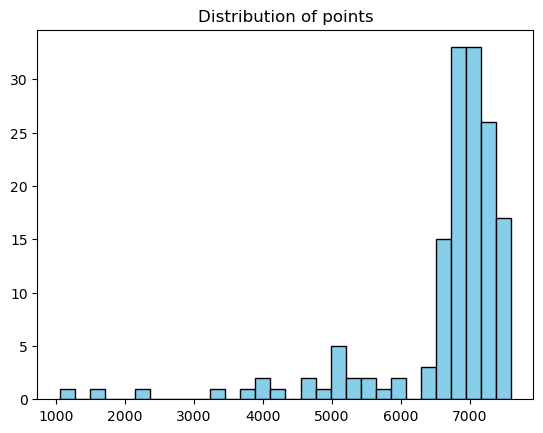

In [333]:
plt.hist(students, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of points')
plt.show()

In [334]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data

# The time each student took to complete the course
times = [(max(student_dict[s]) - min(student_dict[s])).total_seconds() / (60*60*24) for s in students]

# The number of different timestamps, i.e. the number of logs in total done by the student
logs = [len(student_dict[s]) for s in students]

# Finding out on how many different days a student worked on the course
dates = []
all_working_hours = [] #  time of day student tends to work, morning/day/night
pref_work_time = [] # 0 = morning, 1 = day, 2 = night
for s in students:  
    # Taking just the dates from timestamps, 
    # turning them into strings and to get only the unique values, turn the list into set
    uniq_dates = set([ str(d.date()) for d in student_dict[s]])
    # Append it as a list, 
    dates.append(len(uniq_dates)) 
    
    # Take the hour of the timesstamps and log it (morning: 6-12, day: 12-19, night: rest of the time)
    morning, day, night = 0, 0, 0
    hours = [(d.time().hour) for d in student_dict[s]]
    for hour in hours:
        if hour >= 6 and hour < 12:
            morning = morning + 1
        elif hour >= 12 and hour < 19:
            day = day + 1
        else: 
            night = night + 1
            
    # Here just collecting the data
    l = [morning, day, night]
    all_working_hours.append(l)
    # Finding out which index is the biggest to find out when student works the most
    # This is very inelegant, could be done better but let's see if there's something to it.
    m = max(l)
    pref_work_time.append(l.index(m))
    

In [335]:
# Here's a new dataframe for seaborn plotting.
# logs means the amount of logs,
# comp_t means the difference between last and first log, i.e. the course completion time
# log_days is the amount of days that logging has been done
# pref_work_t is the time of the day (morning, day, night) student has most time stamp logs
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time }
df_new = pd.DataFrame(data)


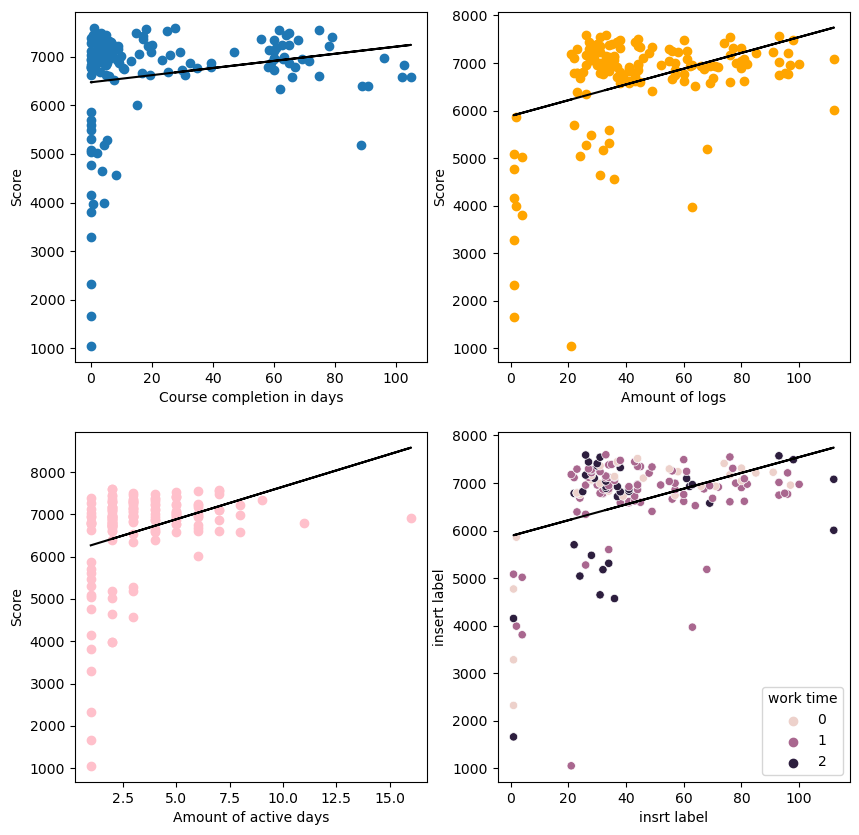

In [336]:
# Actual plotting 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

times_arr = np.array(times)
logs_arr = np.array(logs)
students_arr = np.array(students)
dates_arr = np.array(dates)

# for regression models
time_slope, time_intercept = np.polyfit(times_arr, students_arr, 1)
logs_slope, logs_intercept = np.polyfit(logs_arr, students_arr, 1)
dates_slope, dates_intercept = np.polyfit(dates_arr, students_arr, 1)

ax1.plot(times, students, 'o')
ax1.set_xlabel('Course completion in days')
ax1.set_ylabel('Score')

ax2.plot(logs, students, 'o', color="orange")
ax2.set_xlabel('Amount of logs')
ax2.set_ylabel('Score')

ax3.plot(dates, students, 'o', color="pink")
ax3.set_xlabel('Amount of active days')
ax3.set_ylabel('Score')

sns.scatterplot(x="logs",
                    y="score",
                    hue="pref_work_t",
                    ax=ax4,
                    data=df_new)
                    # palette='Reds' # when hue is used
ax4.set_xlabel('insrt label')
ax4.set_ylabel('insert label')
ax4.legend(title='work time')

ax1.plot(times_arr, time_slope * times_arr + time_intercept, color='black')
ax2.plot(logs_arr, logs_slope * logs_arr + logs_intercept, color='black')
ax3.plot(dates_arr, dates_slope * dates_arr + dates_intercept, color='black')
ax4.plot(logs_arr, logs_slope * logs_arr + logs_intercept, color='black')

plt.show()

Above on the left we can see that most of the students got very high points, a lot of them in a relatively short time interval.
On the right, we can see that the amount of logs can vary a lot for the grade. There is a slight upwards trajectory in the linear regression fitting, but not as distinct as one might expect. 

Bottom left we can see that almost all of the students completed the course with less than 10 days activity logged.

Bottom right is the same as the one above with but just added the different colors for the dots. 0 means students logs were mostly mornings, 1 means during daytime and 0 means during night. There seems to be a lot of morning workers who get good grades.

_Is this gonna be good enough for classification?_

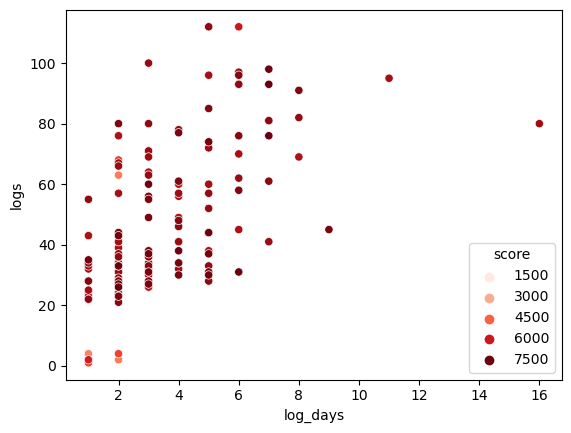

In [337]:
import seaborn as sns


sns.scatterplot(x="log_days",
                    y="logs",
                    hue="score",
                    data=df_new, palette='Reds')
plt.show()

Above we can kinda see a trend: multiple logs over multiple days seems to give a good grade. There is still quite a bit of clustering downish and left, I don't really know what to make of that :/

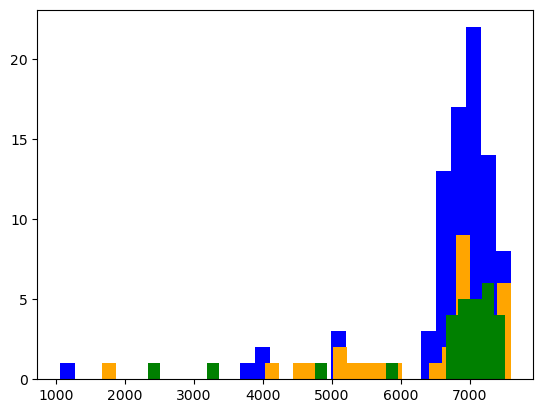

In [339]:
# Student score and prefferred time of day for working
tup = list(zip(students, pref_work_time))

morning_workers = []
day_workers = []
night_workers = []

# Iterate over the list of tuples
for item in tup:
    # Check the second value of the tuple
    if item[1] == 0:
        morning_workers.append(item)
    elif item[1] == 1:
        day_workers.append(item)
    elif item[1] == 2:
        night_workers.append(item)
        
plt.hist([e[0] for e in day_workers], bins=30, color="blue")

plt.hist([e[0] for e in night_workers], bins=30, color="orange")
plt.hist([e[0] for e in morning_workers], bins=30, color="green")

plt.show()

Okay, now I'm just horsing around.

Blue is day workers (most timestamps in the time frame 12-19), orange those who work nights (19 -->) and green is those who tend to work mornings (6-12).

Doesn't look like there's much difference. Looks like maybe morning and day workers are more likely to have very good grades compared to night workers. Dunnolol 

Perhaps we should assume that getting 50% of points means passing --> passing limit is a bit under 4000 --> night workers might be more likely to get shittier grades, compared to the other categories.